In [8]:
import sys
sys.path.append('..')

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from cars_utils import make_training_dataset
%matplotlib inline

# Preprocess

In [9]:
df_dia = pd.read_csv('../tests/csvs/r_dia_k - 1 - Final.csv', index_col=0).dropna(subset=['Numero carro'])
df_noche = pd.read_csv('../tests/csvs/r_noche_k - Final.csv', index_col=0).dropna(subset=['Numero carro'])

df_dia = df_dia[df_dia.frame_number % 2 == 1]
df_dia.frame_number = [int(fn / 2) + 1 for fn in df_dia.frame_number]

df_noche.frame_number = df_noche.frame_number + 37000

df_noche['Numero carro'] = df_noche['Numero carro'] + 158

df = pd.concat([df_dia, df_noche], ignore_index=True)

df = df.drop(columns=['plate', 'plate_confidence', 'Talanquera']).dropna().reset_index(drop=True)

df[['x_centroid', 'y_centroid']] = df.yolo_centroid.str[1:-1].str.split(',', expand=True).astype('float')

df = df.drop(columns=['yolo_centroid'])

df[['Label', 'Numero carro']] = df[['Label', 'Numero carro']].astype('int')

df['gray_mean'] = 0.114*df.b_mean + 0.587*df.g_mean + 0.299*df.r_mean
df = df.drop(columns=['b_mean', 'g_mean', 'r_mean'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30947 entries, 0 to 30946
Data columns (total 9 columns):
frame_number       30947 non-null int64
vehicle_type       30947 non-null object
yolo_rect_area     30947 non-null int64
yolo_confidence    30947 non-null float64
Label              30947 non-null int64
Numero carro       30947 non-null int64
x_centroid         30947 non-null float64
y_centroid         30947 non-null float64
gray_mean          30947 non-null float64
dtypes: float64(4), int64(4), object(1)
memory usage: 2.1+ MB


In [10]:
df['label'] = 0
current_car = 0

for i, car in enumerate(df['Numero carro']):
    if car > current_car:
        df.loc[i, 'label'] = 1
        current_car = car

print(df['Numero carro'].max())
print(df['label'].sum())

238
238


df = pd.read_csv('test_performance.csv', index_col=0)

df.info()

# Train Tree

In [32]:
windows = [1,2,3,4,5,6]

train_df = make_training_dataset(df, windows=windows, drop=['vehicle_type', 'yolo_confidence', 'Label'], label='Numero carro', return_deltas=True)

print(train_df.info())
print(train_df.different_cars.value_counts())
print(str(round(train_df.different_cars.value_counts()[1] / len(train_df) * 100, 2)) + '% are 1s')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185646 entries, 0 to 185645
Data columns (total 17 columns):
ID                      185646 non-null object
frame_number_1          185646 non-null object
yolo_rect_area_1        185646 non-null object
x_centroid_1            185646 non-null object
y_centroid_1            185646 non-null object
gray_mean_1             185646 non-null object
frame_number_2          185646 non-null object
yolo_rect_area_2        185646 non-null object
x_centroid_2            185646 non-null object
y_centroid_2            185646 non-null object
gray_mean_2             185646 non-null object
delta_frame_number      185646 non-null object
delta_yolo_rect_area    185646 non-null object
delta_x_centroid        185646 non-null object
delta_y_centroid        185646 non-null object
delta_gray_mean         185646 non-null object
different_cars          185646 non-null object
dtypes: object(17)
memory usage: 24.1+ MB
None
0    180633
1      5013
Name: different_car

In [27]:
X = train_df.drop(columns=['ID', 'different_cars']).to_numpy()
y = train_df.different_cars.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y)

tree = DecisionTreeClassifier()

param_grid_tree = {'criterion': ['gini','entropy'],
                   'max_depth': [None, 6, 8, 12],
                   'min_samples_split': [8, 12, 16, 20, 24],
                   'min_samples_leaf': [16, 24, 32, 40, 48]}

grid_search_tree =  GridSearchCV(tree, param_grid_tree, cv=3, scoring="roc_auc", n_jobs=-1)
grid_search_tree.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 6, 8, 12],
                       

In [28]:
print(grid_search_tree.best_score_)
print(grid_search_tree.best_params_)

0.9995810355369563
{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 48, 'min_samples_split': 20}


In [29]:
tree_model = grid_search_tree.best_estimator_

In [30]:
tree_model = grid_search_tree.best_estimator_

tree_model.fit(X_train, y_train)
preds = tree_model.predict(X_test)
print(confusion_matrix(y_test, preds))

[[45150    38]
 [   15  1209]]


In [31]:
tree_model.fit(X, y)

with open('tree.pickle', 'wb') as f:
    pickle.dump(tree_model, f)

# Grid Search threshold and windows

In [4]:
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [5]:
g_threshold = [1.5, 1.52, 1.54, 1.56, 1.58, 1.6, 1.62, 1.64, 1.66, 1.68, 1.7, 1.72, 1.74, 1.76, 1.78, 1.8, 1.82, 1.84, 1.86, 1.88, 1.9]
g_windows = [list(s) for s in powerset([1,2,3,4,5,6]) if s]

with open('tree.pickle', 'rb') as h:
    tree = pickle.load(h)
    
df['pred'] = 0
    
gs_results = pd.DataFrame(columns=['windows', 'threshold', 'accuracy', 'precision', 'recall', 'n_vehs'])

# train_df = train_df.drop(columns=['different_cars']).set_index('ID')

# train_df['probas'] = tree.predict_proba(train_df.drop(columns=['probas']))[:, 1] # .drop(columns=['probas'])
    
for windows in g_windows:
    max_window = max(windows)
    len_windows = len(windows)
    
    train_df = make_training_dataset(df, windows=windows, drop=['vehicle_type', 'yolo_confidence', 'Label', 'label', 'Numero carro', 'pred'],
                                     label=None, return_deltas=True).set_index('ID')
#     print(train_df.info())
    train_df['probas'] = tree.predict_proba(train_df)[:, 1] # .drop(columns=['probas'])

    for threshold in g_threshold:
        D_d_s = []
        
        df['pred'] = 0
        df.loc[0, 'pred'] = 1

        for i in df.index[max_window:-max_window]:
            d_s = [train_df.loc[str(i-window) + '_' + str(i), 'probas'] for window in windows]
            D_s = [train_df.loc[str(i) + '_' + str(i+window), 'probas'] for window in windows]
            
            d = sum(d_s) / len(d_s)
            D = sum(D_s) / len(D_s)
            
            D_d = D-d
            
#             print(D_d_s, D_d_s[-1] - D_d)

            if D_d_s and (D_d_s[-1] - D_d > threshold):
                df.loc[i, 'pred'] = 1
                
            D_d_s.append(D_d)
        
        accuracy = (df.label == df.pred).sum() / len(df)
        precision = precision_score(df.label, df.pred)
        recall = recall_score(df.label, df.pred)
        n_vehs = df.pred.sum()
        
        gs_results = gs_results.append({'windows':windows, 'threshold':threshold,
                                        'accuracy':accuracy, 'precision':precision,
                                        'recall':recall, 'n_vehs':n_vehs
                                       }, ignore_index=True)
        gs_results.to_csv('tree_gs_results.csv')
        
#         print(windows, threshold)
#         print('Accuracy:', accuracy)
#         print('Precision:', precision)
#         print('Recall:', recall)
#         print(n_vehs, 'of', df.label.sum(), 'vehs')
#         print(confusion_matrix(df.label, df.pred))
#         print()

In [6]:
gs_results['abs_error'] = (gs_results.n_vehs - 238).abs()
gs_results[gs_results.precision == 1].sort_values(by='abs_error').head(25) # [gs_results.precision == 1]

,windows,threshold,accuracy,precision,recall,n_vehs,abs_error
892,"[1, 2, 3, 5]",1.70,0.999451,1.0,0.928571,221,17
453,"[1, 2, 3]",1.74,0.999451,1.0,0.928571,221,17
891,"[1, 2, 3, 5]",1.68,0.999451,1.0,0.928571,221,17
242,"[2, 3]",1.72,0.999418,1.0,0.924370,220,18
243,"[2, 3]",1.74,0.999418,1.0,0.924370,220,18
913,"[1, 2, 3, 6]",1.70,0.999418,1.0,0.924370,220,18
912,"[1, 2, 3, 6]",1.68,0.999418,1.0,0.924370,220,18
911,"[1, 2, 3, 6]",1.66,0.999418,1.0,0.924370,220,18
896,"[1, 2, 3, 5]",1.78,0.999418,1.0,0.924370,220,18
682,"[2, 3, 5]",1.70,0.999418,1.0,0.924370,220,18


# Use Tree

In [ ]:
windows = [1, 2, 3, 5]
threshold = 1.7

max_window = max(windows)
len_windows = len(windows)

with open('tree.pickle', 'rb') as h:
    tree = pickle.load(h)

train_df = make_training_dataset(df, windows=windows, drop=['vehicle_type', 'yolo_confidence', 'Label', 'label', 'Numero carro'], # 'D_d', 'pred', 
                                 label=None, return_deltas=True).set_index('ID')
# print(train_df.info())
train_df['probas'] = tree.predict_proba(train_df)[:, 1] # .drop(columns=['probas'])

D_d_s = []
error_i_s = []

df['pred'] = 0
df.loc[0, 'pred'] = 1

df['D_d'] = np.nan

for i in df.index[max_window:-max_window]:
    d_s = [train_df.loc[str(i-window) + '_' + str(i), 'probas'] for window in windows]
    D_s = [train_df.loc[str(i) + '_' + str(i+window), 'probas'] for window in windows]

    d = sum(d_s) / len(d_s)
    D = sum(D_s) / len(D_s)

    D_d = D-d
    df.loc[i, 'D_d'] = D_d

#             print(D_d_s, D_d_s[-1] - D_d)

    if D_d_s and (D_d_s[-1] - D_d > threshold):
        df.loc[i, 'pred'] = 1
        
    if df.loc[i, 'pred'] != df.loc[i, 'label']:
        print('pred:', df.loc[i, 'pred'], 'label:', df.loc[i, 'label'])
        error_i_s.append(i)

    D_d_s.append(D_d)


pred: 0 label: 1
pred: 0 label: 1
pred: 0 label: 1
pred: 0 label: 1
pred: 0 label: 1
pred: 0 label: 1
pred: 0 label: 1
pred: 0 label: 1
pred: 0 label: 1
pred: 0 label: 1
pred: 0 label: 1
pred: 0 label: 1


error at index: 8618 ; frame: 19442


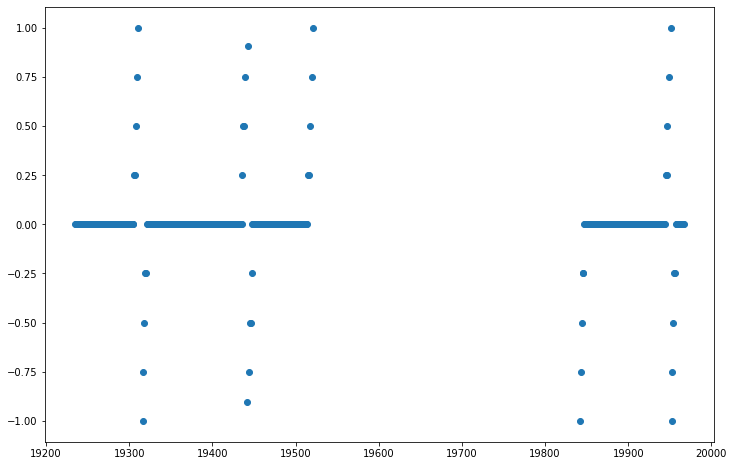

In [5]:
ii = 2
x0 = error_i_s[ii]
print('error at index:', x0, '; frame:', df.loc[x0, 'frame_number'])
lim = 200
plt.figure(figsize=(12, 8))
plt.scatter(x=df.loc[df.index[x0-lim: x0+lim], 'frame_number'], y=df.loc[df.index[x0-lim: x0+lim], 'D_d'])

In [6]:
df['error'] = 0

df.loc[error_i_s, 'error'] = 1

In [7]:
df[7520:7527]

,frame_number,vehicle_type,yolo_rect_area,yolo_confidence,Label,Numero carro,x_centroid,y_centroid,gray_mean,label,pred,D_d,error
7520,17805,car,454800,0.940444,1,66,548.0,420.0,87.154991,0,0,0.250000,0
7521,17806,car,468860,0.668456,1,66,495.0,422.5,86.814856,0,0,0.500000,0
7522,17808,car,494740,0.330808,1,66,440.5,422.0,81.539504,0,0,0.750000,0
7523,17812,car,74360,0.991424,1,67,785.0,198.0,72.060210,1,0,-0.812500,1
7524,17813,car,85008,0.984446,1,67,783.0,205.0,72.127533,0,0,-0.562500,0
7525,17814,car,317408,0.802733,1,66,369.0,502.0,79.181613,0,0,0.562500,0
7526,17815,car,288147,0.174185,1,66,355.5,507.5,80.126935,0,0,0.781888,0


In [8]:
df['vehicle_number'] = df.pred.cumsum()

In [35]:
tt = time.time()
current_car = 0
for i in df.index:
    if df.loc[i, 'pred'] == 1:
        current_car += 1
    df.loc[i, 'vehicle_number'] = current_car
    
df[['vehicle_number']] = df[['vehicle_number']].astype('int')
print(time.time() - tt)

24.343921661376953


In [79]:
df[7520:7527]

,frame_number,vehicle_type,yolo_rect_area,yolo_confidence,Label,Numero carro,x_centroid,y_centroid,gray_mean,label,pred,D_d,error,vehicle_number
7520,17805,car,454800,0.940444,1,66,548.0,420.0,87.154991,0,0,0.250000,0,66
7521,17806,car,468860,0.668456,1,66,495.0,422.5,86.814856,0,0,0.500000,0,66
7522,17808,car,494740,0.330808,1,66,440.5,422.0,81.539504,0,0,0.750000,0,66
7523,17812,car,74360,0.991424,1,67,785.0,198.0,72.060210,1,0,-0.812500,1,66
7524,17813,car,85008,0.984446,1,67,783.0,205.0,72.127533,0,0,-0.562500,0,66
7525,17814,car,317408,0.802733,1,66,369.0,502.0,79.181613,0,0,0.562500,0,66
7526,17815,car,288147,0.174185,1,66,355.5,507.5,80.126935,0,0,0.781888,0,66


In [76]:
cars_with_errors = sorted(list(set(df.loc[df['error'] == 1, 'vehicle_number'])))
print(len(cars_with_errors), cars_with_errors)

15 [66, 73, 74, 78, 104, 107, 123, 141, 150, 156, 170, 198, 204, 219, 221]


In [77]:
g_pctg_of_apprcs_to_rm = np.arange(0.13,0.18,0.01)

for pctg_of_apprcs_to_rm in g_pctg_of_apprcs_to_rm:

    good_sum_neg_deltas = []
    bad_sum_neg_deltas = []

    for car in df.vehicle_number.unique():
        car_df = df[df.vehicle_number == car]
        number_of_apprcs = len(car_df)

        if pctg_of_apprcs_to_rm != 0:
            cars_to_remove = int(round(number_of_apprcs * pctg_of_apprcs_to_rm / 2))
            car_df = car_df[cars_to_remove: -cars_to_remove]

        number_of_apprcs = len(car_df)

        deltas_D_d = list(car_df.D_d.diff().dropna())
        sum_neg_deltas = sum([-delta for delta in deltas_D_d if delta < 0])

        if car in cars_with_errors:
            bad_sum_neg_deltas.append(sum_neg_deltas)
        else:
            good_sum_neg_deltas.append(sum_neg_deltas)
            
    min_bad = min(bad_sum_neg_deltas)

    n_good_above_min_bad = len([good for good in good_sum_neg_deltas if good >= 0.62])

    print(pctg_of_apprcs_to_rm)
    print(min(bad_sum_neg_deltas))
    print(max(good_sum_neg_deltas))
    print(n_good_above_min_bad)
    print()

0.13
0.862480935434672
1.7421286410966124
2

0.14
0.862480935434672
1.7421286410966124
2

0.15000000000000002
0.862480935434672
0.8979591836734694
1

0.16000000000000003
0.862480935434672
0.8979591836734694
1

0.17000000000000004
0.862480935434672
0.8979591836734694
1



In [80]:
pctg_of_apprcs_to_rm = 0.15
not_one_car_threshold = 0.62

bad_cars = []

n_not_one_car = -1

for car in df.vehicle_number.unique():
    car_df = df[df.vehicle_number == car]
    number_of_apprcs = len(car_df)

    if pctg_of_apprcs_to_rm != 0:
        cars_to_remove = int(round(number_of_apprcs * pctg_of_apprcs_to_rm / 2))
        car_df = car_df[cars_to_remove: -cars_to_remove]

    number_of_apprcs = len(car_df)

    deltas_D_d = list(car_df.D_d.diff().dropna())
    sum_neg_deltas = sum([-delta for delta in deltas_D_d if delta < 0])

    if sum_neg_deltas >= not_one_car_threshold:
        df.loc[df.vehicle_number == car, 'vehicle_number'] = n_not_one_car
        print('Car', car, 'is "not-really-one-car"', n_not_one_car)
        bad_cars.append(car)
        n_not_one_car -= 1

Car 66 is "not-really-one-car" -1
Car 73 is "not-really-one-car" -2
Car 74 is "not-really-one-car" -3
Car 78 is "not-really-one-car" -4
Car 104 is "not-really-one-car" -5
Car 107 is "not-really-one-car" -6
Car 123 is "not-really-one-car" -7
Car 141 is "not-really-one-car" -8
Car 150 is "not-really-one-car" -9
Car 156 is "not-really-one-car" -10
Car 170 is "not-really-one-car" -11
Car 198 is "not-really-one-car" -12
Car 204 is "not-really-one-car" -13
Car 219 is "not-really-one-car" -14
Car 220 is "not-really-one-car" -15
Car 221 is "not-really-one-car" -16


In [21]:
df[7520:7527]

,frame_number,vehicle_type,yolo_rect_area,yolo_confidence,Label,Numero carro,x_centroid,y_centroid,gray_mean,label,pred,D_d,error,vehicle_number
7520,17805,car,454800,0.940444,1,66,548.0,420.0,87.154991,0,0,0.250000,0,-1
7521,17806,car,468860,0.668456,1,66,495.0,422.5,86.814856,0,0,0.500000,0,-1
7522,17808,car,494740,0.330808,1,66,440.5,422.0,81.539504,0,0,0.750000,0,-1
7523,17812,car,74360,0.991424,1,67,785.0,198.0,72.060210,1,0,-0.812500,1,-1
7524,17813,car,85008,0.984446,1,67,783.0,205.0,72.127533,0,0,-0.562500,0,-1
7525,17814,car,317408,0.802733,1,66,369.0,502.0,79.181613,0,0,0.562500,0,-1
7526,17815,car,288147,0.174185,1,66,355.5,507.5,80.126935,0,0,0.781888,0,-1


# Find which are cars

In [42]:
car_areas = []
non_car_areas = []

for car in df['Numero carro'].unique():
    car_df = df[df['Numero carro'] == car]
    types = car_df.Label.unique()
    veh_type = types[0]
    mean_area = car_df.yolo_rect_area.mean()
    if veh_type == 1:
        car_areas.append(mean_area)
    else:
        print(car)
        non_car_areas.append(mean_area)

58
71
121
154
159
205
209
233


In [41]:
print(max(car_areas))
print(min(non_car_areas))

358332.3333333333
166209.8396226415


In [43]:
print(len([area for area in car_areas if area >= min(non_car_areas)]))

192


In [37]:
non_car_areas

[173583.42857142858,
 167345.86363636365,
 237201.77777777778,
 212299.54054054053,
 166758.0,
 195690.29487179487,
 166209.8396226415,
 166619.7]